In [1]:
from resram_core import load_input, resram_data, param_init, raman_residual, run_save
from tqdm.notebook import tqdm
import time
from datetime import datetime
import numpy as np
import lmfit


c:\Users\Kent\OneDrive - University of Rochester\Documents\Lab\fsrsanalysis\resram_ipynb\resram_core.py:638: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig_raman.show()
c:\Users\Kent\OneDrive - University of Rochester\Documents\Lab\fsrsanalysis\resram_ipynb\resram_core.py:673: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig_profs.show()
c:\Users\Kent\OneDrive - University of Rochester\Documents\Lab\fsrsanalysis\resram_ipynb\resram_core.py:684: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig_abs.show()


Elapsed time: 7.4988157749176025 seconds


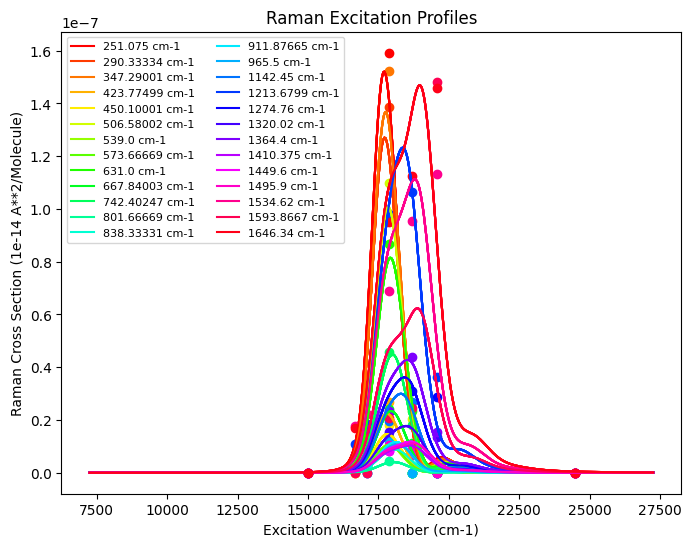

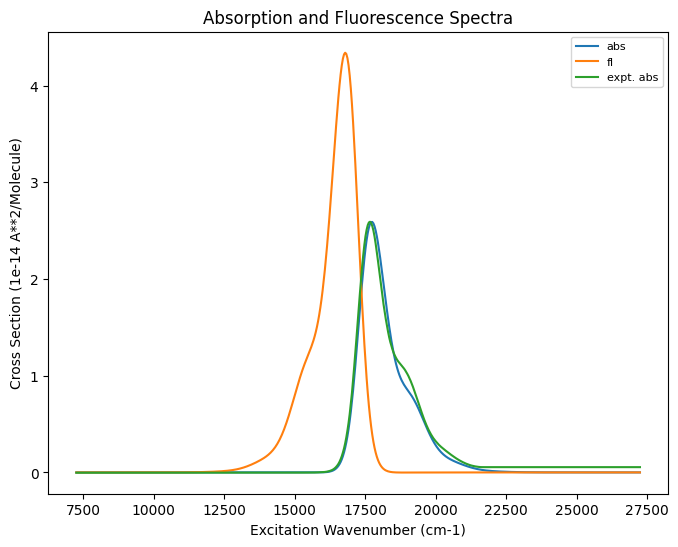

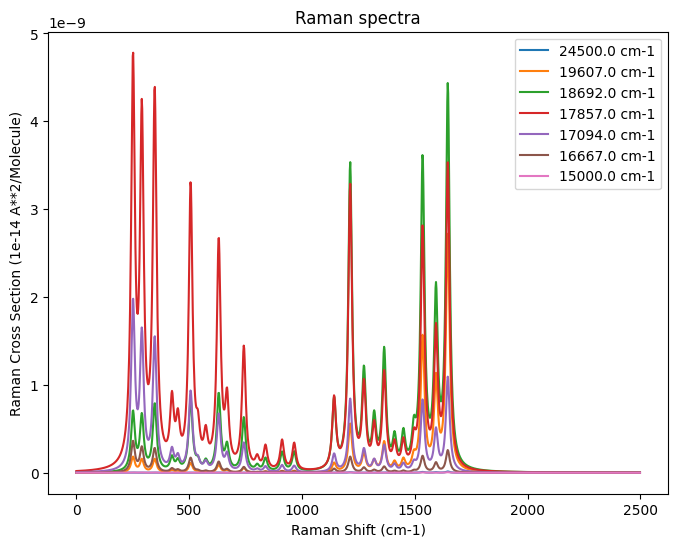

In [2]:
# Count time for loading data and simulation
start_time = time.time()
for i in range(30):
    data = resram_data() #load input data from current directory and calculate cross sections
data.plot()
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

In [3]:
start_time = time.time()
for i in range(100):
    fit_obj = load_input()
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")
print(fit_obj.rp)

Elapsed time: 0.7007782459259033 seconds
[430 308 285 265 246 235 193]


<Parameter 'delta0', value=0.7748604270679489, bounds=[0.0:1.0]>
<Parameter 'delta1', value=0.6409960961625931, bounds=[0.0:1.0]>
<Parameter 'delta2', value=0.5872857740485251, bounds=[0.0:1.0]>
<Parameter 'delta3', value=0.20719247724224388, bounds=[0.0:1.0]>
<Parameter 'delta4', value=0.1607544533791192, bounds=[0.0:1.0]>
<Parameter 'delta5', value=0.3893313623373211, bounds=[0.0:1.0]>
<Parameter 'delta6', value=0.12074773193374017, bounds=[0.0:1.0]>
<Parameter 'delta7', value=0.11603393193686784, bounds=[0.0:1.0]>
<Parameter 'delta8', value=0.30537623378500867, bounds=[0.0:1.0]>
<Parameter 'delta9', value=0.15836620976768084, bounds=[0.0:1.0]>
<Parameter 'delta10', value=0.20742166396327966, bounds=[0.0:1.0]>
<Parameter 'delta11', value=0.060015796848877534, bounds=[0.0:1.0]>
<Parameter 'delta12', value=0.08745576005571493, bounds=[0.0:1.0]>
<Parameter 'delta13', value=0.0968567706185624, bounds=[0.0:1.0]>
<Parameter 'delta14', value=0.0916268892643442, bounds=[0.0:1.0]>
<Parameter 

Fitting progress:   0%|          | 0/100 [00:00<?, ?it/s]

[[Fit Statistics]]
    # fitting method   = COBYLA
    # function evals   = 100
    # data points      = 3
    # variables        = 30
    chi-square         = 0.05150164
    reduced chi-square = 0.05150164
    Akaike info crit   = 47.8057383
    Bayesian info crit = 20.7641070
##  Warning: uncertainties could not be estimated:
[[Variables]]
    delta0:             0.65576515 (init = 0.7748604)
    delta1:             0.68011010 (init = 0.6409961)
    delta2:             0.52086726 (init = 0.5872858)
    delta3:             0.04051769 (init = 0.2071925)
    delta4:             0.08731071 (init = 0.1607545)
    delta5:             0.38170554 (init = 0.3893314)
    delta6:             0.11989742 (init = 0.1207477)
    delta7:             0.11410878 (init = 0.1160339)
    delta8:             0.29874730 (init = 0.3053762)
    delta9:             0.20169679 (init = 0.1583662)
    delta10:            0.20124691 (init = 0.2074217)
    delta11:            0.11107437 (init = 0.0600158)
    delt

"\nplt.plot(np.arange(len(correlation_list)), np.array(\n    correlation_list)*50, label='correlation*50')\nplt.plot(np.arange(len(sigma_list)), sigma_list, label='sigma')\nplt.plot(np.arange(len(loss_list)), loss_list, label='loss')\nplt.legend(loc='best')\nplt.show()"

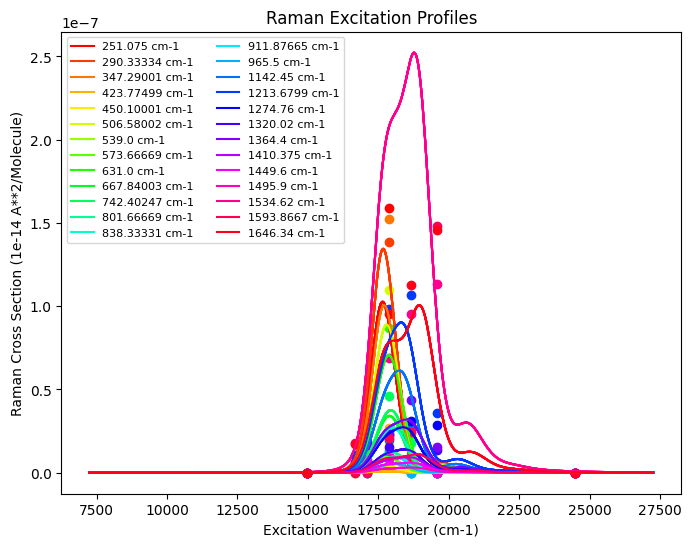

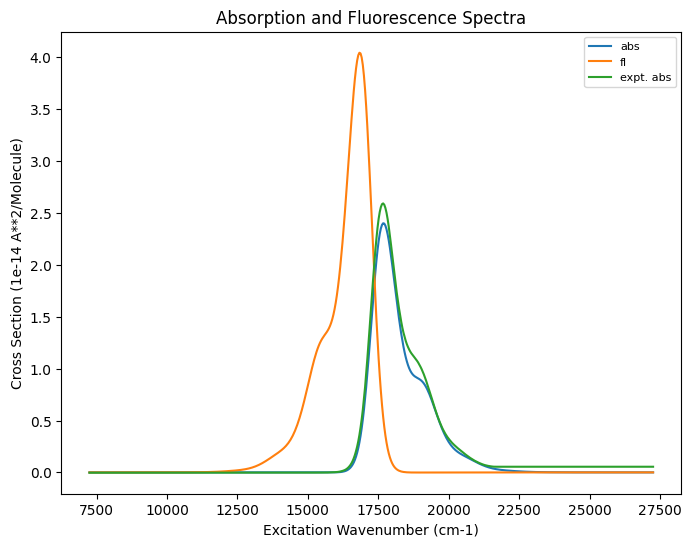

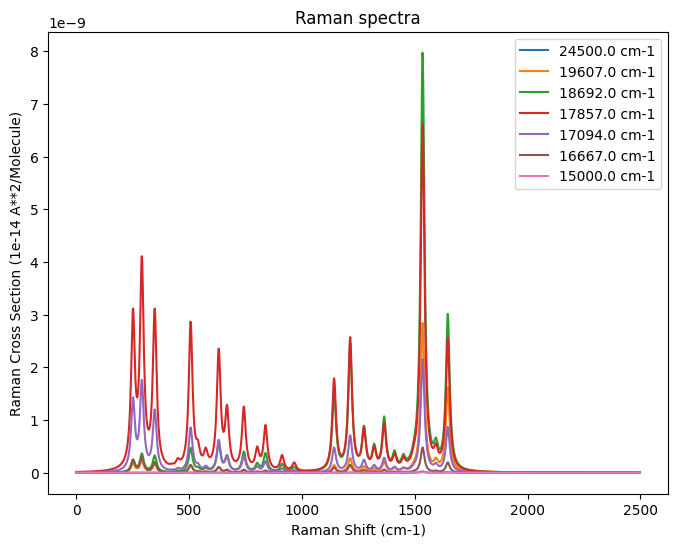

In [ ]:
fit_obj = load_input() # Initialize the 'fit_obj' object of class 'load_input' .Load from input files in root dir or specified dir

fit_switch = np.ones(len(fit_obj.delta)+7)
fit_switch[len(fit_obj.delta)] = 1  # fit gamma?
fit_switch[len(fit_obj.delta)+1] = 1  # fit M?
fit_switch[len(fit_obj.delta)+2] = 1  # fit theta?
fit_switch[len(fit_obj.delta)+3] = 1  # fit kappa?
fit_switch[len(fit_obj.delta)+5] = 0  # fit E0?

params_lmfit = param_init(fit_switch,fit_obj)   # Initialize parameters for fitting using 'param_init' function
# params_lmfit.add('gamma',value = 600,min = 400, max = 900)
# params_lmfit.add('transition_length',value = 1.83,min = 1.5, max = 2.3)
for name in params_lmfit.keys():
    print(params_lmfit[name])
raman_residual(params_lmfit)   # Calculate initial residuals for Raman spectroscopy
print(fit_obj.correlation)
fit_kws = dict(tol=1e-9)    # Set fitting tolerance
max_nfev = 100    # Set maximum number of function evaluations
# Initialize tqdm progress bar for fitting process
with tqdm(total=max_nfev, desc="Fitting progress") as pbar:
    def update_progress(params, iteration, resid,args):
        # Update tqdm progress bar with fitting information
        # global correlation, total_sigma
        pbar.update(1)
        #print(iteration,resid,args)
        try:
            
            pbar.set_description(
                f"Iteration {iteration}, Total Residual: {resid[0]:.7f}, Abs_corr: {fit_obj.correlation:.7f}, raman_sigma: {fit_obj.total_sigma:.7f}, delta: {fit_obj.delta}, M: {fit_obj.M}, Theta: {fit_obj.theta}, Kappa: {fit_obj.k}, E0: {fit_obj.E0}")
        except Exception as e:
            print(f"Error in update_progress: {e}")
            pass
     # Perform the fitting using lmfit.minimize function
    result = lmfit.minimize(raman_residual, params_lmfit, args=(fit_obj,), method='cobyla', **fit_kws,
                            max_nfev=max_nfev, iter_cb=update_progress)  # max_nfev = 10000000, **fit_kws

print(lmfit.fit_report(result))
delta_fit = fit_obj.delta.copy()
current_time_str = datetime.now().strftime("%Y%m%d_%H-%M-%S") 
output = run_save(fit_obj,current_time_str)  # save all parameters and results to a new folder
output.plot()

np.savetxt(current_time_str+"_data/corr_list.dat", fit_obj.correlation_list)
np.savetxt(current_time_str+"_data/sigma_list.dat", fit_obj.sigma_list)
np.savetxt(current_time_str+"_data/loss_list", fit_obj.loss_list)
#np.savetxt(current_time_str+"_data/delta_fit.dat",delta_fit,delimiter = "\t") #save deltas. already saved with run_save()
'''
plt.plot(np.arange(len(correlation_list)), np.array(
    correlation_list)*50, label='correlation*50')
plt.plot(np.arange(len(sigma_list)), sigma_list, label='sigma')
plt.plot(np.arange(len(loss_list)), loss_list, label='loss')
plt.legend(loc='best')
plt.show()'''


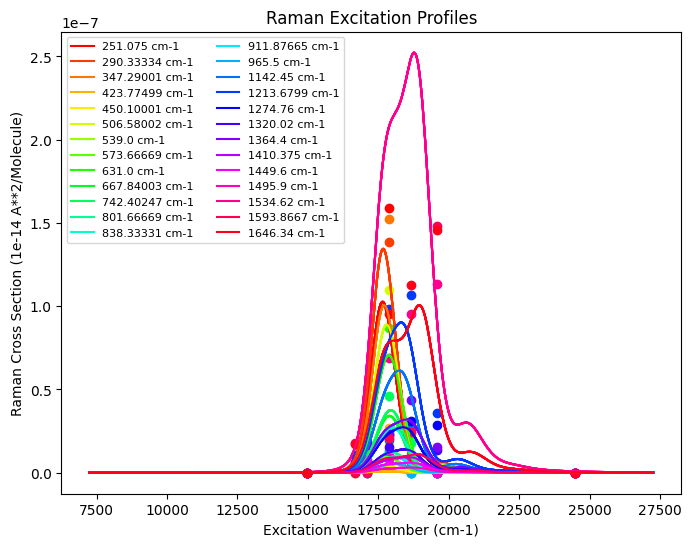

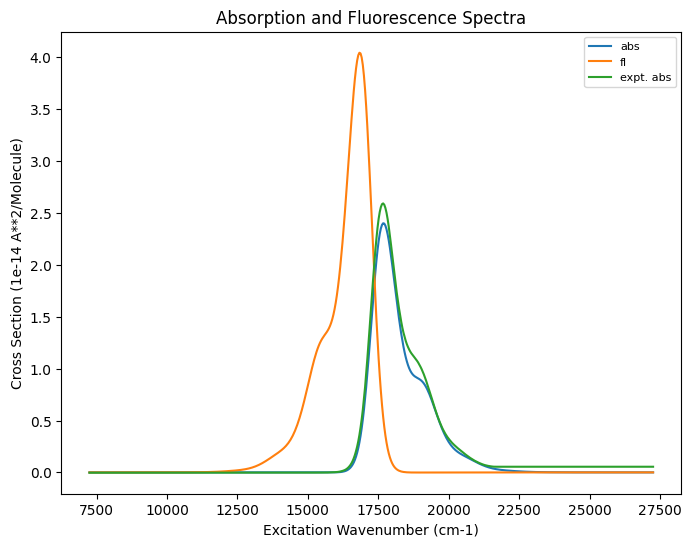

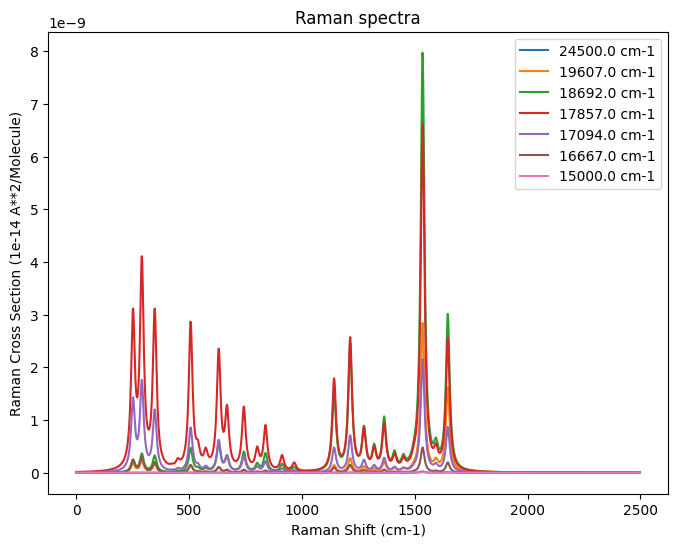

In [4]:
output.plot()

[-4.01531184e-06 -4.16922581e-06 -4.17601367e-06 -4.05012528e-06
 -3.84847853e-06 -3.65339215e-06 -3.54715965e-06 -3.58611081e-06
 -3.78232998e-06 -4.09895189e-06 -4.46079557e-06 -4.77729530e-06
 -4.97074840e-06 -5.00108081e-06 -4.87925133e-06 -4.66483788e-06
 -4.44824694e-06 -4.32284474e-06 -4.35559346e-06 -4.56542033e-06
 -4.91629525e-06 -5.32749526e-06 -5.69816521e-06 -5.93871837e-06
 -5.99931454e-06 -5.88637871e-06 -5.66171305e-06 -5.42413381e-06
 -5.27907275e-06 -5.30548621e-06 -5.53045032e-06 -5.91960484e-06
 -6.38677458e-06 -6.82011755e-06 -7.11688578e-06 -7.21601185e-06
 -7.11820449e-06 -6.88696945e-06 -6.62985406e-06 -6.46543506e-06
 -6.48617333e-06 -6.72876412e-06 -7.16147914e-06 -7.69282912e-06
 -8.19923958e-06 -8.56339264e-06 -8.71135873e-06 -8.63678757e-06
 -8.40427428e-06 -8.13042513e-06 -7.94814910e-06 -7.96509991e-06
 -8.22925485e-06 -8.71262537e-06 -9.31859646e-06 -9.91105161e-06
 -1.03565341e-05 -1.05664107e-05 -1.05257437e-05 -1.02995001e-05
 -1.00136901e-05 -9.81687

c:\Users\Kent\OneDrive - University of Rochester\Documents\Lab\fsrsanalysis\resram_ipynb\resram_core.py:636: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig_raman.show()
c:\Users\Kent\OneDrive - University of Rochester\Documents\Lab\fsrsanalysis\resram_ipynb\resram_core.py:671: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig_profs.show()
c:\Users\Kent\OneDrive - University of Rochester\Documents\Lab\fsrsanalysis\resram_ipynb\resram_core.py:682: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig_abs.show()


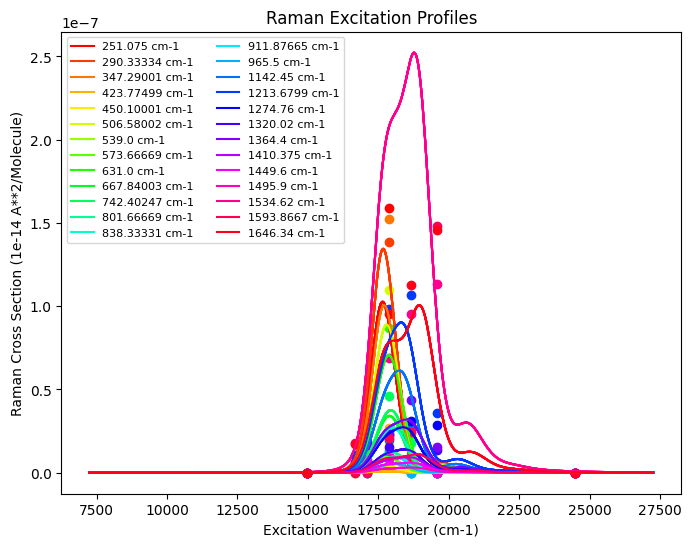

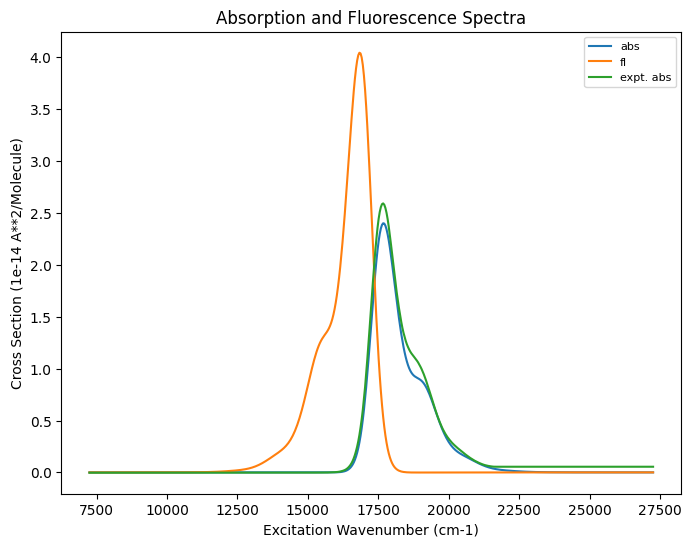

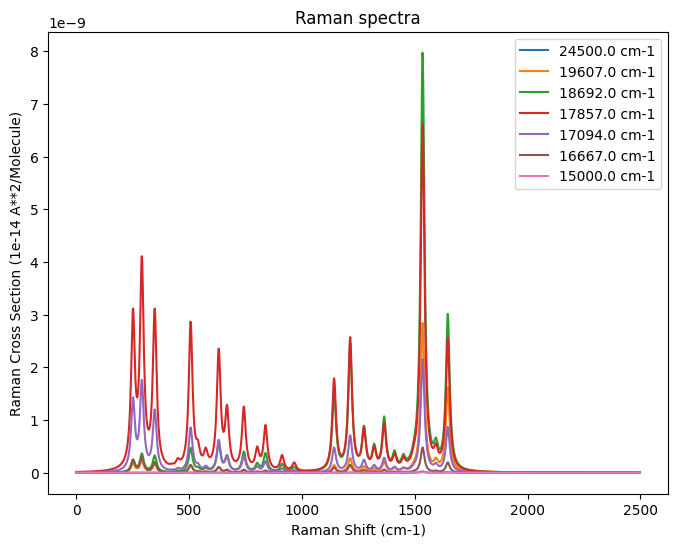

In [2]:
output = resram_data("20250604_13-08-34_data")
print(output.abs)
output.plot()

